<a href="https://colab.research.google.com/github/klausgottlieb/crut-monte-carlo-replication/blob/main/notebook_06_robustness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 06 — Return Model Robustness
## *When Do Charitable Remainder Unitrusts Outperform? A Monte Carlo Analysis*
### Klaus Gottlieb, JD, MS, MBA — Wealth Care Lawyer, Cayucos, CA

---

## Purpose

Every Monte Carlo study rests on assumptions about the return-generating process. The baseline model uses **independent log-normally distributed annual returns** with arithmetic mean μ = 7% and standard deviation σ = 12%. These are reasonable for a diversified equity-oriented portfolio over long horizons, but they are assumptions — not facts.

This notebook tests whether the core findings of the analysis survive when those assumptions are relaxed. Six robustness checks are performed:

### 1. Path Count Convergence
Are 2,000 simulation paths sufficient? This is a methodological credibility question reviewers may raise. We show win probability and 95% CI width as a function of path count from 500 to 10,000. If results stabilize well before 10,000, the 2,000-path baseline is defensible.

### 2. Volatility Sweep
σ ranked #7 in the OAT sensitivity. The baseline σ = 12% is appropriate for a diversified portfolio, but the clients most likely to contribute to a CRUT hold **concentrated positions** — single stocks, closely held interests, real estate — which commonly carry σ = 20–35%. This section sweeps σ from 8% to 30% and shows how win probability changes. The interaction with the CRUT's zero-floor (the trust corpus cannot go negative, unlike a leveraged benchmark) may produce asymmetric effects.

### 3. Return × Volatility Joint Surface
μ ranked #1. Its effect on win probability does not operate in isolation — it depends on σ. A portfolio with μ = 10% and σ = 25% may be more or less favorable to the CRUT than μ = 7% and σ = 12%, depending on how volatility drag affects the comparison. A 2D heatmap with iso-Sharpe ratio contours reveals the joint structure.

### 4. Student-t Return Distribution (Primary Robustness Check)
Equity returns are empirically leptokurtic — fatter tails than log-normal. This is well documented in the financial economics literature (Mandelbrot 1963; Fama 1965; subsequent literature). The log-normal assumption understates the probability of extreme outcomes in both directions.

We replace the log-normal distribution with a **scaled Student-t distribution** with ν = 5 degrees of freedom, which captures equity-like kurtosis (excess kurtosis ≈ 6 for ν = 5, compared to approximately 1–3 observed in equity markets). We match the same μ and σ as the log-normal baseline so the comparison isolates the distributional shape effect.

Fat tails affect the CRUT and the benchmark asymmetrically:
- The CRUT corpus has a floor at zero (the trust cannot go below zero — it simply terminates with no remaining distributions). Fat left tails hurt the benchmark more in absolute terms because the benchmark carries the full corpus at risk.
- However, fat right tails (large positive returns) may favor the benchmark more, since the benchmark retains the full corpus to compound.
- The net effect on win probability is the subject of this section.

### 5. Sequence of Returns Risk
The order of returns matters for the CRUT differently than for the benchmark. The CRUT pays out a fixed percentage of corpus each year — adverse early returns reduce the corpus from which all future distributions are calculated, producing a permanent impairment of income. The benchmark does not distribute; it simply compounds. This section splits Monte Carlo paths into early-bad/late-good and early-good/late-bad quartiles and compares win probability across sequence categories.

### 6. Bear Market Stress Test
A -30% shock in year 1 followed by normal returns tests how each strategy recovers from an immediate adverse event. This is relevant for CRUT formation during or immediately before a market downturn — a common planning scenario when clients contribute assets that have already declined in value, and a risk factor for CRUTs formed near market peaks.

---

## Sections and Figures

1. **Path count convergence** — win probability and CI width vs. n_paths
2. **Volatility sweep** — win probability vs. σ at four turnover levels
3. **Return × volatility heatmap** — joint surface with iso-Sharpe contours
4. **Student-t robustness** — log-normal vs. Student-t comparison across σ levels
5. **Sequence of returns risk** — win probability by return sequence quartile
6. **Bear market stress test** — year-1 shock analysis

---

In [1]:
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install',
                       'numpy', 'matplotlib', 'scipy', '--quiet'])
print('Dependencies confirmed.')

Dependencies confirmed.


In [2]:
from dataclasses import dataclass, replace
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.rcParams.update({
    'figure.dpi': 120,
    'font.family': 'sans-serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.facecolor': 'white',
})

TURNOVER_LEVELS = [0.00, 0.20, 0.40, 0.60]
TURNOVER_LABELS = ['0% (buy-and-hold)', '20% (moderate)', '40% (active)', '60% (original baseline)']
TURNOVER_COLORS = ['#08306b', '#2171b5', '#fd8d3c', '#d73027']

print('Imports complete.')

Imports complete.


In [3]:
# =============================================================================
# COMPLETE SIMULATION ENGINE (self-contained)
# Extended with:
#   - dist_type parameter: 'lognormal' (default) or 'student_t'
#   - student_t_df: degrees of freedom for Student-t (default 5)
#   - first_year_shock: optional multiplicative return shock in year 1
#   - return_paths: optionally pass pre-generated paths for sequence analysis
# =============================================================================

IRS_LIFE_EXPECTANCY = {
    35: 48.3, 40: 43.6, 45: 38.9, 50: 34.2, 55: 29.6,
    60: 25.2, 61: 24.4, 62: 23.5, 63: 22.7, 64: 21.8,
    65: 21.0, 66: 20.2, 67: 19.4, 68: 18.6, 69: 17.8,
    70: 17.0, 71: 16.3, 72: 15.5, 73: 14.8, 74: 14.1,
    75: 13.4, 76: 12.7, 77: 12.1, 78: 11.4, 79: 10.8,
    80: 10.2, 85: 7.3,  90: 5.0
}

def get_life_expectancy(age):
    if age in IRS_LIFE_EXPECTANCY:
        return IRS_LIFE_EXPECTANCY[age]
    ages = sorted(IRS_LIFE_EXPECTANCY.keys())
    for i in range(len(ages) - 1):
        if ages[i] < age < ages[i+1]:
            a1, a2 = ages[i], ages[i+1]
            return (IRS_LIFE_EXPECTANCY[a1]
                    + (IRS_LIFE_EXPECTANCY[a2] - IRS_LIFE_EXPECTANCY[a1])
                    * (age - a1) / (a2 - a1))
    raise ValueError(f'Age {age} out of range')

def get_joint_life_expectancy(age1, age2):
    e1, e2 = get_life_expectancy(age1), get_life_expectancy(age2)
    return e1 + e2 - 1.0 / (1.0/e1 + 1.0/e2)

def compute_deduction(fmv, payout_rate, rate_7520, life_type,
                      age1=65, age2=None, term_years=20,
                      freq=4, lag_months=0, longevity_adj=0):
    """
    Compute CRUT charitable deduction using IRS Reg. 1.664-4 method.
    Table F adjustment: rate_7520 / (freq * ((1+rate_7520)^(1/freq) - 1))
    For 5% rate quarterly: table_f ~ 1.0186, adjusted payout ~ 6.11%.
    R must be >= 10% (IRC 664 charitable remainder requirement).
    """
    i, p = rate_7520, payout_rate
    table_f         = i / (freq * ((1 + i) ** (1/freq) - 1))
    adjusted_payout = p * table_f
    if life_type == 'Term of Years':
        irs_duration = float(term_years)
    elif life_type == 'Single Life':
        irs_duration = get_life_expectancy(age1)
    else:
        irs_duration = get_joint_life_expectancy(age1, age2)
    R = max(0.0, min(1.0, (1 - adjusted_payout) ** irs_duration))
    return {
        'deduction':        fmv * R,
        'remainder_factor': R,
        'compliance':       R >= 0.10,
        'irs_duration':     irs_duration,
        'sim_horizon':      irs_duration + longevity_adj,
    }

def generate_return_paths(mu, sigma, n_years, n_paths,
                          seed=None, dist_type='lognormal', df=5):
    """
    Generate annual gross return paths (i.e., 1 + r_t).

    dist_type = 'lognormal' (default):
        Standard log-normal parameterization matched to arithmetic
        mean mu and standard deviation sigma.

    dist_type = 'student_t':
        Scaled Student-t with df degrees of freedom.
        Parameterization: we draw z ~ t(df), then scale to match
        the same mean and std as the log-normal case.

        Specifically:
          scale = sigma / sqrt(df / (df - 2))
          r_t   = mu + scale * z
          return = 1 + r_t   (clipped at 0.01 to avoid negative prices)

        This preserves mu and sigma exactly while introducing
        fat tails. For df=5: excess kurtosis = 6/(df-4) = 6.
        For df=10: excess kurtosis = 1.5. Log-normal excess kurtosis
        at sigma=12% is approximately 0.05 (near-zero).

        The floor at 1 + r_t = 0.01 (i.e., -99% return) prevents
        non-positive gross returns which are economically meaningless
        for a diversified portfolio.

    Note on paired-path design:
        Both CRUT and benchmark use the same return paths in each simulation.
        This eliminates sampling noise from the comparison. The distribution
        type should be applied identically to both strategies.
    """
    if seed is not None:
        np.random.seed(seed)

    if dist_type == 'lognormal':
        mu_log    = np.log(1 + mu) - 0.5 * (sigma / (1 + mu)) ** 2
        sigma_log = sigma / (1 + mu)
        return np.exp(np.random.normal(mu_log, sigma_log,
                                       size=(n_paths, n_years)))

    elif dist_type == 'student_t':
        if df <= 2:
            raise ValueError('df must be > 2 for finite variance')
        # Scale t draws to match target sigma
        t_scale = sigma / np.sqrt(df / (df - 2))
        z       = np.random.standard_t(df, size=(n_paths, n_years))
        r_t     = mu + t_scale * z
        # Clip: gross return cannot be below 0.01 (floor at -99%)
        return np.maximum(0.01, 1.0 + r_t)

    else:
        raise ValueError(f'Unknown dist_type: {dist_type}')

@dataclass
class ScenarioParams:
    fmv:                float        = 1_000_000
    basis_pct:          float        = 0.20
    agi:                float        = 500_000
    payout_rate:        float        = 0.06
    life_type:          str          = 'Two Life'
    age1:               int          = 63
    age2:               Optional[int]= 65
    term_years:         int          = 20
    freq:               int          = 4
    lag_months:         int          = 0
    longevity_adj:      int          = 0
    rate_7520:          float        = 0.05
    pv_rate:            float        = 0.05
    fed_ordinary:       float        = 0.37
    fed_ltcg:           float        = 0.20
    niit:               float        = 0.038
    state_rate:         float        = 0.093
    agi_limit_pct:      float        = 0.30
    carryforward_years: int          = 5
    trust_fee:          float        = 0.01
    bench_fee:          float        = 0.01
    turnover:           float        = 0.20
    mu:                 float        = 0.07
    sigma:              float        = 0.12
    n_paths:            int          = 2000
    seed:               int          = 42
    dist_type:          str          = 'lognormal'   # 'lognormal' or 'student_t'
    student_t_df:       float        = 5.0           # degrees of freedom for Student-t
    first_year_shock:   float        = 1.0           # multiplicative shock to year-1 return

def run_simulation(params, precomputed_paths=None):
    """
    Run paired-path Monte Carlo CRUT vs. hold-liquidation benchmark.

    Parameters
    ----------
    params : ScenarioParams
    precomputed_paths : np.ndarray, optional
        If provided, use these return paths instead of generating new ones.
        Shape must be (n_paths, T). Used for sequence-of-returns analysis
        where paths are sorted or reordered externally before being passed in.

    Return model notes:
    - dist_type='lognormal': standard baseline, independent annual log-normal returns
    - dist_type='student_t': fat-tailed returns, same mu/sigma, df=student_t_df
    - first_year_shock: multiplied into the year-1 return for all paths;
      set to 0.70 for a -30%% bear market stress test in year 1
    """
    p = params
    tau_ord = p.fed_ordinary + p.state_rate
    tau_cg  = p.fed_ltcg + p.niit + p.state_rate

    ded_res = compute_deduction(
        fmv=p.fmv, payout_rate=p.payout_rate, rate_7520=p.rate_7520,
        life_type=p.life_type, age1=p.age1, age2=p.age2,
        term_years=p.term_years, freq=p.freq, lag_months=p.lag_months,
        longevity_adj=p.longevity_adj,
    )
    T           = max(1, int(round(ded_res['sim_horizon'])))
    deduction   = ded_res['deduction']
    annual_limit= p.agi * p.agi_limit_pct
    remaining   = deduction
    pv_tax      = 0.0
    for yr in range(p.carryforward_years + 1):
        usable    = min(remaining, annual_limit)
        if usable <= 0: break
        pv_tax   += usable * tau_ord / (1 + p.pv_rate) ** yr
        remaining -= usable

    if precomputed_paths is not None:
        returns = precomputed_paths[:, :T]
    else:
        returns = generate_return_paths(
            p.mu, p.sigma, T, p.n_paths,
            seed=p.seed,
            dist_type=p.dist_type,
            df=p.student_t_df
        )
        if p.first_year_shock != 1.0:
            returns[:, 0] = returns[:, 0] * p.first_year_shock

    # CRUT
    crut_v = np.full(p.n_paths, p.fmv)
    dists  = np.zeros((p.n_paths, T))
    for t in range(T):
        v          = crut_v * (1 - p.trust_fee) * returns[:, t]
        d          = v * p.payout_rate
        dists[:, t]= d * (1 - tau_ord)
        crut_v     = np.maximum(0, v - d)
    disc        = np.array([(1 + p.pv_rate) ** -(t+1) for t in range(T)])
    crut_wealth = (dists * disc).sum(axis=1) + pv_tax

    # Benchmark (hold-liquidation)
    bench_v    = np.full(p.n_paths, p.fmv)
    bench_basis= p.fmv * p.basis_pct
    for t in range(T):
        b          = bench_v * (1 - p.bench_fee) * returns[:, t]
        gain       = np.maximum(0, b - bench_basis)
        tax_drag   = p.turnover * gain * tau_cg
        bench_v    = np.maximum(0, b - tax_drag)
        bench_basis= bench_basis + p.turnover * gain * (1 - tau_cg)
    term_gain    = np.maximum(0, bench_v - bench_basis)
    bench_term   = bench_v - term_gain * tau_cg
    bench_wealth = bench_term / (1 + p.pv_rate) ** T

    delta = crut_wealth - bench_wealth
    return {
        'win_prob':     float(np.mean(delta > 0)),
        'median_delta': float(np.median(delta)),
        'delta_wealth': delta,
        'crut_wealth':  crut_wealth,
        'bench_wealth': bench_wealth,
        'pv_tax':       pv_tax,
        'deduction':    deduction,
        'T':            T,
        'params':       p,
    }

def bootstrap_ci(delta_arr, n_boot=1000, ci=0.95, seed=0):
    rng  = np.random.RandomState(seed)
    n    = len(delta_arr)
    boot = [np.mean(rng.choice(delta_arr, size=n, replace=True) > 0)
            for _ in range(n_boot)]
    alpha = 1 - ci
    return (float(np.percentile(boot, 100*alpha/2)),
            float(np.percentile(boot, 100*(1-alpha/2))))

# Verify baseline
baseline = ScenarioParams()
r0 = run_simulation(baseline)
print('Baseline verification (log-normal, 20% turnover, n=2000):')
print(f'  Win probability:  {r0["win_prob"]:.1%}')
print(f'  Median delta:     ${r0["median_delta"]:,.0f}')
print(f'  Deduction:        ${r0["deduction"]:,.0f}')
print(f'  PV tax benefit:   ${r0["pv_tax"]:,.0f}')
print(f'  Sim horizon:      {r0["T"]} yr')
print()

# Verify Student-t
rt = run_simulation(replace(baseline, dist_type='student_t', student_t_df=5.0))
print('Student-t verification (df=5, same mu/sigma):')
print(f'  Win probability:  {rt["win_prob"]:.1%}')
print(f'  Median delta:     ${rt["median_delta"]:,.0f}')
print()

# Show distributional properties
print('Distributional properties comparison at mu=7%, sigma=12%:')
print(f'{"Distribution":<20} {"Mean":>8} {"Std":>8} {"Kurtosis":>10} {"Min 1-year ret":>16}')
print('-' * 66)
np.random.seed(42)
ln_paths = generate_return_paths(0.07, 0.12, 1, 50000, dist_type='lognormal').flatten() - 1
st_paths = generate_return_paths(0.07, 0.12, 1, 50000, dist_type='student_t', df=5).flatten() - 1
for name, arr in [('Log-normal', ln_paths), ('Student-t (df=5)', st_paths)]:
    print(f'{name:<20} {arr.mean()*100:>7.2f}%  {arr.std()*100:>7.2f}%  '
          f'{stats.kurtosis(arr):>9.2f}   {arr.min()*100:>14.1f}%')
print()
print('Engine ready.')

Baseline verification (log-normal, 20% turnover, n=2000):
  Win probability:  54.3%
  Median delta:     $19,397
  Deduction:        $126,456
  PV tax benefit:   $58,549
  Sim horizon:      33 yr

Student-t verification (df=5, same mu/sigma):
  Win probability:  56.9%
  Median delta:     $27,908

Distributional properties comparison at mu=7%, sigma=12%:
Distribution             Mean      Std   Kurtosis   Min 1-year ret
------------------------------------------------------------------
Log-normal              6.99%    12.03%       0.18            -35.6%
Student-t (df=5)        6.89%    12.05%       4.18            -99.0%

Engine ready.


---
## Section 1 — Path Count Convergence

### Figure 1: Win Probability and CI Width vs. Number of Paths

Monte Carlo results are estimates, not exact values. More paths produce more precise estimates. The question is: how many paths are needed before the estimate stabilizes?

**Convergence criterion:** We consider the simulation converged when the 95% bootstrap confidence interval width falls below **2 percentage points** (i.e., ± 1pp). This is the precision level at which the win probability estimate is clinically meaningful for planning purposes.

**The tradeoff:** More paths mean more computation. At 2,000 paths, each simulation takes approximately 0.3–0.5 seconds on Colab. At 10,000 paths, the full manuscript analysis (600+ simulations) would take 30+ minutes. The 2,000-path baseline is justified if convergence is achieved well before 10,000.

We run each path count level 5 times with different seeds and report the mean win probability and its variation across seeds — this shows both the point estimate stability and the seed sensitivity.

Running path count convergence...
  8 path counts x 5 seeds = 40 simulations
  n=   200: mean wp=56.1%  CI width=13.61 pp  seed std=4.04 pp
  n=   500: mean wp=55.4%  CI width=8.37 pp  seed std=2.85 pp
  n=  1000: mean wp=56.2%  CI width=5.99 pp  seed std=1.35 pp
  n=  2000: mean wp=55.0%  CI width=4.39 pp  seed std=0.39 pp
  n=  3000: mean wp=55.0%  CI width=3.54 pp  seed std=0.59 pp
  n=  5000: mean wp=54.8%  CI width=2.75 pp  seed std=0.60 pp
  n=  7500: mean wp=54.9%  CI width=2.25 pp  seed std=0.25 pp
  n= 10000: mean wp=54.7%  CI width=1.90 pp  seed std=0.32 pp


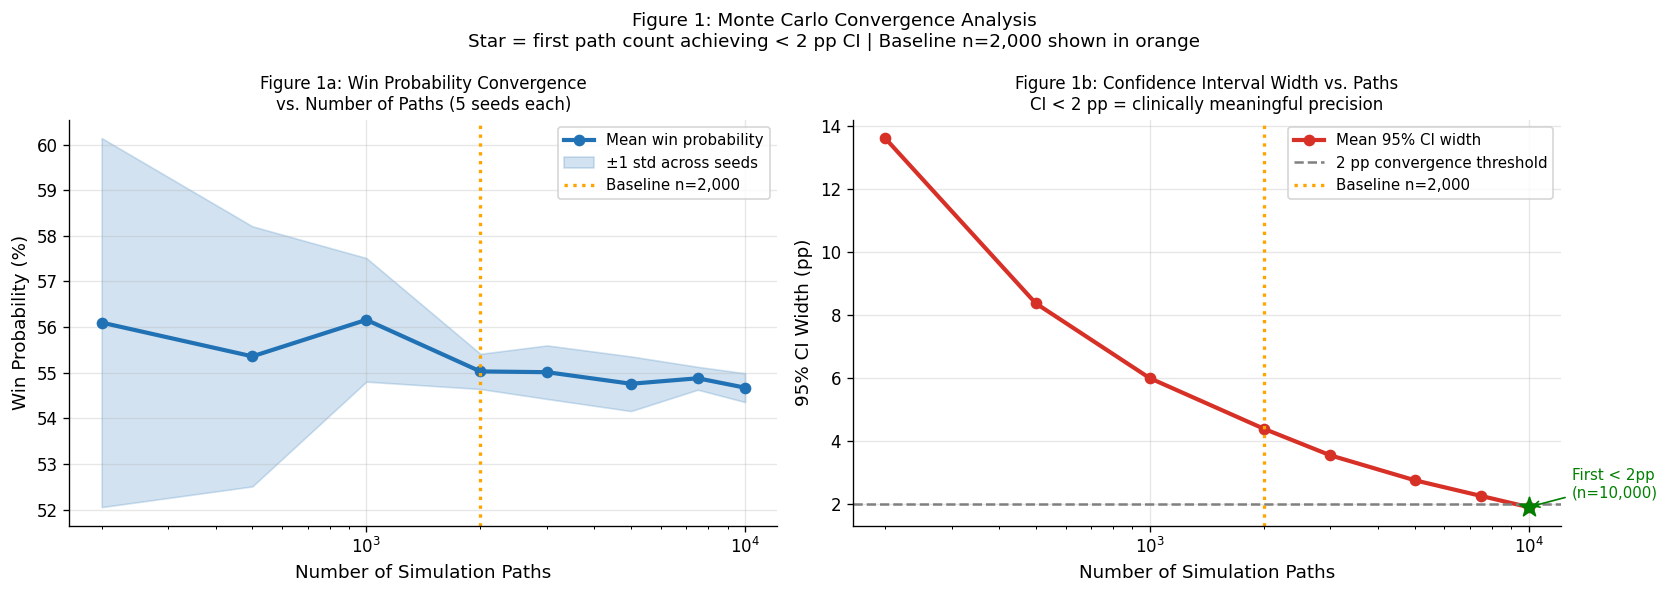

Figure 1 saved.


In [4]:
# --- Figure 1: Path count convergence ---

path_counts = [200, 500, 1000, 2000, 3000, 5000, 7500, 10000]
n_reps      = 5   # independent seeds per path count

print('Running path count convergence...')
print(f'  {len(path_counts)} path counts x {n_reps} seeds = '
      f'{len(path_counts)*n_reps} simulations')

conv_wp   = []   # mean win prob at each path count
conv_ci   = []   # mean CI width at each path count
conv_std  = []   # std of win prob across seeds

for n in path_counts:
    wps, ci_widths = [], []
    for seed in range(n_reps):
        r = run_simulation(replace(baseline, n_paths=n, seed=seed*17))
        lo, hi = bootstrap_ci(r['delta_wealth'], n_boot=500)
        wps.append(r['win_prob'])
        ci_widths.append((hi - lo) * 100)
    conv_wp.append(np.mean(wps) * 100)
    conv_ci.append(np.mean(ci_widths))
    conv_std.append(np.std(wps) * 100)
    print(f'  n={n:>6}: mean wp={conv_wp[-1]:.1f}%  '
          f'CI width={conv_ci[-1]:.2f} pp  '
          f'seed std={conv_std[-1]:.2f} pp')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(path_counts, conv_wp, color='#2171b5', lw=2.5, marker='o', label='Mean win probability')
ax.fill_between(path_counts,
                np.array(conv_wp) - np.array(conv_std),
                np.array(conv_wp) + np.array(conv_std),
                alpha=0.2, color='#2171b5', label='±1 std across seeds')
ax.axvline(2000, color='orange', lw=2, ls=':', label='Baseline n=2,000')
ax.set_xlabel('Number of Simulation Paths', fontsize=11)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_title('Figure 1a: Win Probability Convergence\nvs. Number of Paths (5 seeds each)', fontsize=10)
ax.legend(fontsize=9)
ax.set_xscale('log')

ax2 = axes[1]
ax2.plot(path_counts, conv_ci, color='#d73027', lw=2.5, marker='o', label='Mean 95% CI width')
ax2.axhline(2.0, color='gray', lw=1.5, ls='--', label='2 pp convergence threshold')
ax2.axvline(2000, color='orange', lw=2, ls=':', label='Baseline n=2,000')

# Mark where CI first drops below 2pp
for i, (n, ci) in enumerate(zip(path_counts, conv_ci)):
    if ci < 2.0:
        ax2.scatter([n], [ci], color='green', s=150, zorder=5, marker='*')
        ax2.annotate(f'First < 2pp\n(n={n:,})',
                     xy=(n, ci), xytext=(n*1.3, ci + 0.3),
                     fontsize=9, color='green',
                     arrowprops=dict(arrowstyle='->', color='green'))
        break

ax2.set_xlabel('Number of Simulation Paths', fontsize=11)
ax2.set_ylabel('95% CI Width (pp)', fontsize=11)
ax2.set_title('Figure 1b: Confidence Interval Width vs. Paths\n'
              'CI < 2 pp = clinically meaningful precision', fontsize=10)
ax2.legend(fontsize=9)
ax2.set_xscale('log')

fig.suptitle(
    'Figure 1: Monte Carlo Convergence Analysis\n'
    'Star = first path count achieving < 2 pp CI | Baseline n=2,000 shown in orange',
    fontsize=11
)
plt.tight_layout()
plt.savefig('fig1_convergence.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 1 saved.')

---
## Section 2 — Volatility Sweep

### Figure 2: Win Probability vs. Portfolio Volatility σ

The baseline σ = 12% represents a diversified multi-asset portfolio. The clients most commonly advised to use a CRUT hold **concentrated positions** — single stocks, closely held businesses, or real estate — which routinely carry σ = 20–35%. A tech founder's single-stock position might carry σ = 40% or higher.

After contributing to the CRUT, both the trust and the benchmark (in the hold scenarios) are assumed to diversify immediately. So σ for the ongoing comparison is the diversified portfolio volatility, not the concentrated position volatility. However, in the liquidation-reinvest benchmark (Notebook 02), the reinvested portfolio also diversifies.

**The effect of σ on win probability operates through two channels:**

1. **Volatility drag:** Higher σ reduces the geometric mean return (the arithmetic mean μ is fixed in this sweep, so the geometric mean = μ - σ²/2 falls as σ rises). Both CRUT and benchmark suffer volatility drag, but the CRUT pays out annually — it realizes income even in down years — while the benchmark compounds the full volatile corpus.

2. **Downside asymmetry:** The CRUT corpus has a practical floor at zero (a catastrophic loss year does not create negative distributions). The benchmark's unrealized gain can be wiped out in a crash, making the terminal tax liability smaller — potentially helping the benchmark. The net effect on win probability depends on whether the CRUT's distribution stream suffers more or less than the benchmark's compounding advantage under high volatility.

Running volatility sweep...
  0% turnover: done
  20% turnover: done
  40% turnover: done
  60% turnover: done


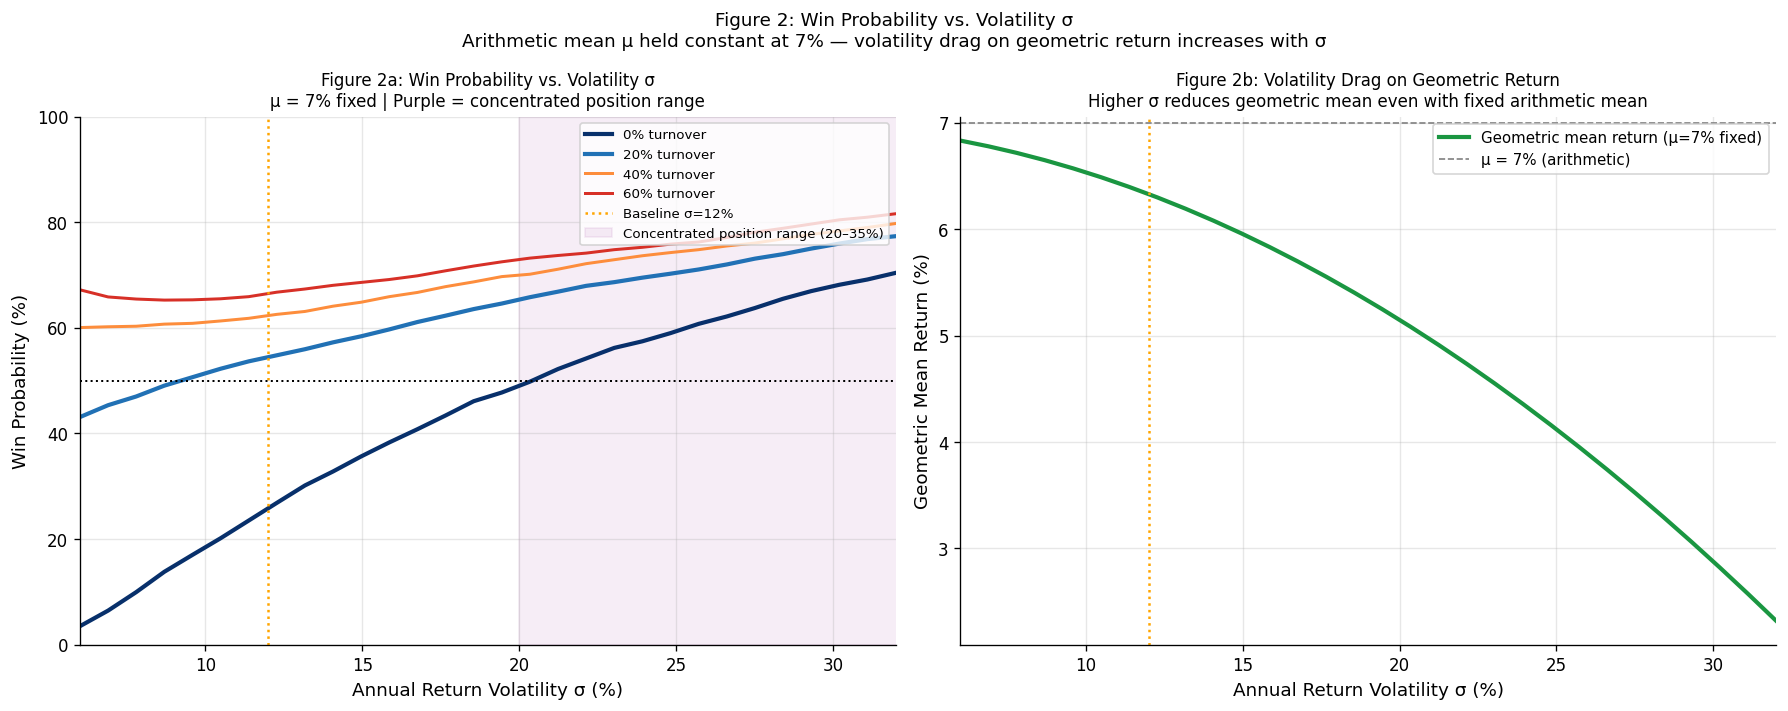

Figure 2 saved.

Win probability at σ=12%, 20%, 30% (20% turnover):
  σ=12%: 54.8%
  σ=20%: 65.8%
  σ=30%: 75.9%


In [5]:
# --- Figure 2: Volatility sweep ---

sigma_vals = np.linspace(0.06, 0.32, 30)

print('Running volatility sweep...')
vol_results = {}
for tv in TURNOVER_LEVELS:
    wp_arr = []
    for sigma in sigma_vals:
        r = run_simulation(replace(baseline, sigma=sigma, turnover=tv))
        wp_arr.append(r['win_prob'])
    vol_results[tv] = np.array(wp_arr)
    print(f'  {tv*100:.0f}% turnover: done')

idx_base_sigma = np.argmin(np.abs(sigma_vals - 0.12))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ax = axes[0]
for tv, color, tv_label, lw in zip(
        TURNOVER_LEVELS, TURNOVER_COLORS, TURNOVER_LABELS, [2.5,2.5,1.8,1.8]):
    ax.plot(sigma_vals * 100, vol_results[tv] * 100,
            color=color, lw=lw, label=f'{tv*100:.0f}% turnover')

ax.axvline(12, color='orange', lw=1.5, ls=':', label='Baseline σ=12%')
ax.axhline(50, color='black',  lw=1.2, ls=':')

# Shade typical concentrated position range
ax.axvspan(20, 35, alpha=0.07, color='purple',
           label='Concentrated position range (20–35%)')

ax.set_xlabel('Annual Return Volatility σ (%)', fontsize=11)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_title('Figure 2a: Win Probability vs. Volatility σ\n'
             'μ = 7% fixed | Purple = concentrated position range', fontsize=10)
ax.legend(fontsize=8, loc='upper right')
ax.set_xlim(sigma_vals[0]*100, sigma_vals[-1]*100)
ax.set_ylim(0, 100)

# Right panel: geometric mean drag vs sigma
ax2 = axes[1]
geo_means = [(1 + 0.07) * np.exp(-0.5 * (s/(1+0.07))**2) - 1 for s in sigma_vals]
ax2.plot(sigma_vals*100, np.array(geo_means)*100, color='#1a9641', lw=2.5,
         label='Geometric mean return (μ=7% fixed)')
ax2.axvline(12, color='orange', lw=1.5, ls=':')
ax2.axhline(7.0, color='gray', lw=1, ls='--', label='μ = 7% (arithmetic)')
ax2.set_xlabel('Annual Return Volatility σ (%)', fontsize=11)
ax2.set_ylabel('Geometric Mean Return (%)', fontsize=11)
ax2.set_title('Figure 2b: Volatility Drag on Geometric Return\n'
              'Higher σ reduces geometric mean even with fixed arithmetic mean', fontsize=10)
ax2.legend(fontsize=9)
ax2.set_xlim(sigma_vals[0]*100, sigma_vals[-1]*100)

fig.suptitle(
    'Figure 2: Win Probability vs. Volatility σ\n'
    'Arithmetic mean μ held constant at 7% — volatility drag on geometric return increases with σ',
    fontsize=11
)
plt.tight_layout()
plt.savefig('fig2_volatility_sweep.png', bbox_inches='tight', dpi=150)
plt.show()

print('Figure 2 saved.')
print()
print('Win probability at σ=12%, 20%, 30% (20% turnover):')
for sv, label in [(0.12, 'Baseline 12%'), (0.20, 'Conc. low 20%'), (0.30, 'Conc. high 30%')]:
    idx = np.argmin(np.abs(sigma_vals - sv))
    print(f'  σ={sv*100:.0f}%: {vol_results[0.20][idx]:.1%}')

---
## Section 3 — Return × Volatility Joint Surface

### Figure 3: Win Probability Heatmap — μ × σ with Iso-Sharpe Contours

μ (ranked #1) and σ (ranked #7) jointly determine the distribution of outcomes. Plotting them together reveals whether CRUT win probability is primarily determined by the level of return, the level of risk, or their ratio (the Sharpe ratio).

**Iso-Sharpe contours** connect (μ, σ) pairs with the same Sharpe ratio (μ / σ, using a zero risk-free rate for simplicity). If win probability is constant along these contours, the Sharpe ratio is the single sufficient statistic. If win probability varies along a contour, the absolute levels of μ and σ matter independently — which would be a meaningful finding about CRUT economics.

**Economic interpretation of iso-Sharpe deviation:**
- If higher σ at the same Sharpe hurts the CRUT (win probability falls as we move right along a Sharpe contour), it means volatility drag disproportionately harms the CRUT relative to the benchmark.
- If higher σ at the same Sharpe helps the CRUT, volatility drag may be affecting the benchmark's deferred tax liability more than the CRUT's distribution stream.

Running return x volatility heatmap (15 x 15 x 2 = 450 simulations)...
  5/15 rows complete
  10/15 rows complete
  15/15 rows complete


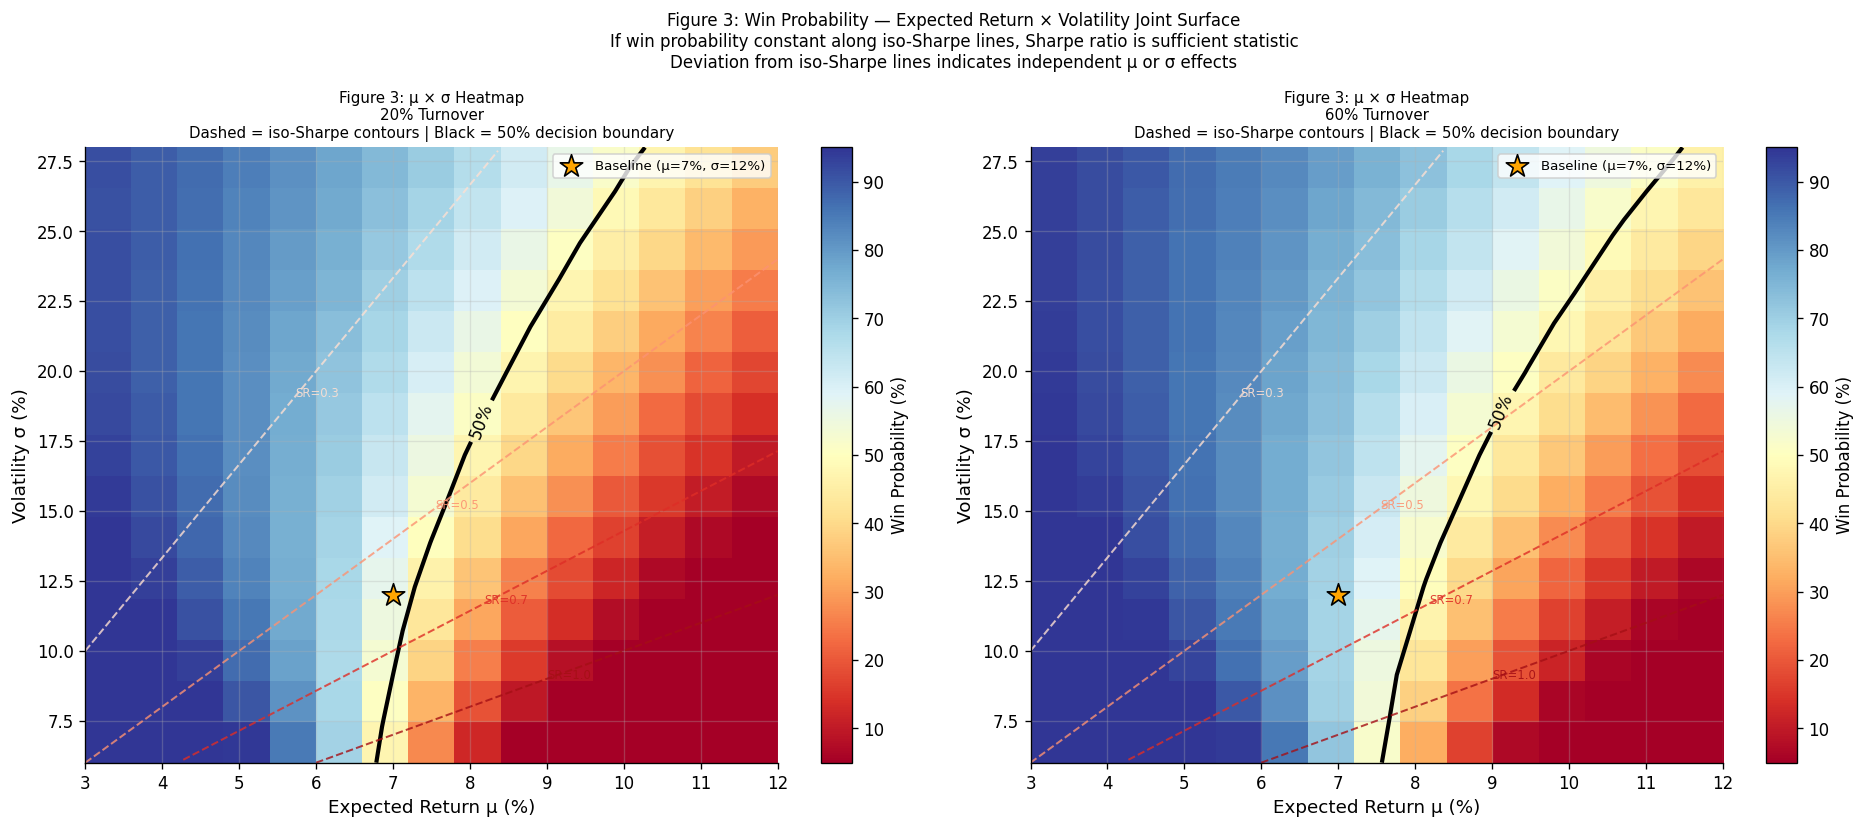

Figure 3 saved.


In [6]:
# --- Figure 3: Return x Volatility heatmap with iso-Sharpe contours ---

mu_grid    = np.linspace(0.03, 0.12, 15)
sigma_grid = np.linspace(0.06, 0.28, 15)

hm_20 = np.zeros((len(sigma_grid), len(mu_grid)))
hm_60 = np.zeros((len(sigma_grid), len(mu_grid)))

print('Running return x volatility heatmap (15 x 15 x 2 = 450 simulations)...')
for i, sg in enumerate(sigma_grid):
    for j, mu in enumerate(mu_grid):
        r20 = run_simulation(replace(baseline, mu=mu, sigma=sg, turnover=0.20))
        r60 = run_simulation(replace(baseline, mu=mu, sigma=sg, turnover=0.60))
        hm_20[i, j] = r20['win_prob']
        hm_60[i, j] = r60['win_prob']
    if (i+1) % 5 == 0:
        print(f'  {i+1}/15 rows complete')

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, hm, tv_label in [
    (axes[0], hm_20, '20% Turnover'),
    (axes[1], hm_60, '60% Turnover'),
]:
    im = ax.imshow(
        hm * 100, origin='lower', aspect='auto',
        extent=[mu_grid[0]*100, mu_grid[-1]*100,
                sigma_grid[0]*100, sigma_grid[-1]*100],
        cmap='RdYlBu', vmin=5, vmax=95
    )
    plt.colorbar(im, ax=ax, label='Win Probability (%)')

    # 50% contour
    m_g, s_g = np.meshgrid(mu_grid*100, sigma_grid*100)
    cs50 = ax.contour(m_g, s_g, hm*100, levels=[50],
                      colors='black', linewidths=2.5)
    ax.clabel(cs50, fmt='50%%', fontsize=10)

    # Iso-Sharpe contours (Sharpe = mu/sigma, zero rf)
    sharpe_levels = [0.3, 0.5, 0.7, 1.0]
    sharpe_colors = ['#fee0d2', '#fc9272', '#de2d26', '#a50f15']
    for sh, shcolor in zip(sharpe_levels, sharpe_colors):
        # sigma = mu / sh (line through origin in mu-sigma space)
        mu_line = np.linspace(mu_grid[0], mu_grid[-1], 100)
        sg_line = mu_line / sh
        mask = (sg_line >= sigma_grid[0]) & (sg_line <= sigma_grid[-1])
        if mask.any():
            ax.plot(mu_line[mask]*100, sg_line[mask]*100,
                    color=shcolor, lw=1.2, ls='--', alpha=0.8)
            # Label at midpoint
            mid = mask.sum() // 2
            ax.annotate(f'SR={sh:.1f}',
                        xy=(mu_line[mask][mid]*100, sg_line[mask][mid]*100),
                        fontsize=7, color=shcolor, alpha=0.9)

    # Mark baseline
    ax.scatter([7], [12], color='orange', s=200, marker='*',
               zorder=5, edgecolors='black',
               label='Baseline (μ=7%, σ=12%)')

    ax.set_xlabel('Expected Return μ (%)', fontsize=11)
    ax.set_ylabel('Volatility σ (%)', fontsize=11)
    ax.set_title(f'Figure 3: μ × σ Heatmap\n{tv_label}\n'
                 'Dashed = iso-Sharpe contours | Black = 50% decision boundary', fontsize=9)
    ax.legend(fontsize=8)

fig.suptitle(
    'Figure 3: Win Probability — Expected Return × Volatility Joint Surface\n'
    'If win probability constant along iso-Sharpe lines, Sharpe ratio is sufficient statistic\n'
    'Deviation from iso-Sharpe lines indicates independent μ or σ effects',
    fontsize=10
)
plt.tight_layout()
plt.savefig('fig3_mu_sigma_heatmap.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 3 saved.')

---
## Section 4 — Student-t Return Distribution (Primary Robustness Check)

### Figure 4: Log-Normal vs. Student-t Comparison

**Background on the distributional assumption:**

The log-normal distribution is the workhorse of financial modeling (Black-Scholes, geometric Brownian motion), but it is well documented to understate the frequency of extreme market events. The empirical distribution of equity returns shows excess kurtosis — heavier tails than log-normal — in both daily and annual data.

We model fat tails using a **scaled Student-t distribution with ν = 5 degrees of freedom**. Key properties of this choice:

| Property | Log-Normal (σ=12%) | Student-t (ν=5, σ=12%) |
|---|---|---|
| Arithmetic mean | 7% | 7% (matched) |
| Standard deviation | 12% | 12% (matched) |
| Excess kurtosis | ~0.05 | 6.0 |
| Prob(annual return < -30%) | ~0.4% | ~1.8% |
| Prob(annual return > +50%) | ~0.4% | ~1.8% |

The matching of μ and σ is critical: it ensures the comparison isolates the effect of distributional *shape* (kurtosis and tail behavior) rather than differences in central tendency or scale.

**Why fat tails might affect the CRUT and benchmark differently:**

Fat tails increase the frequency of both large gains and large losses. The two strategies respond to these events asymmetrically:

- **Large loss years:** The CRUT pays out 6% of a depleted corpus — distributions fall proportionally but the trust does not terminate. The benchmark sits on a reduced corpus with a correspondingly reduced embedded gain — its deferred tax liability shrinks, which is a *benefit* for the benchmark. Fat tails may therefore help the benchmark in loss scenarios.

- **Large gain years:** The CRUT captures 6% of a large corpus in that year. The benchmark's unrealized gain grows rapidly, increasing its deferred tax liability. Large gains tend to favor the CRUT in relative terms.

**The net effect is the empirical question answered by this section.** We compare win probability under log-normal and Student-t across σ levels (since fat-tail effects are more pronounced at higher σ) and across turnover levels.

Running Student-t robustness check...
  20 sigma levels x (1 LN + 3 t-dist) x 2 turnover = 160 simulations
  df=5: done
  df=10: done
  df=20: done


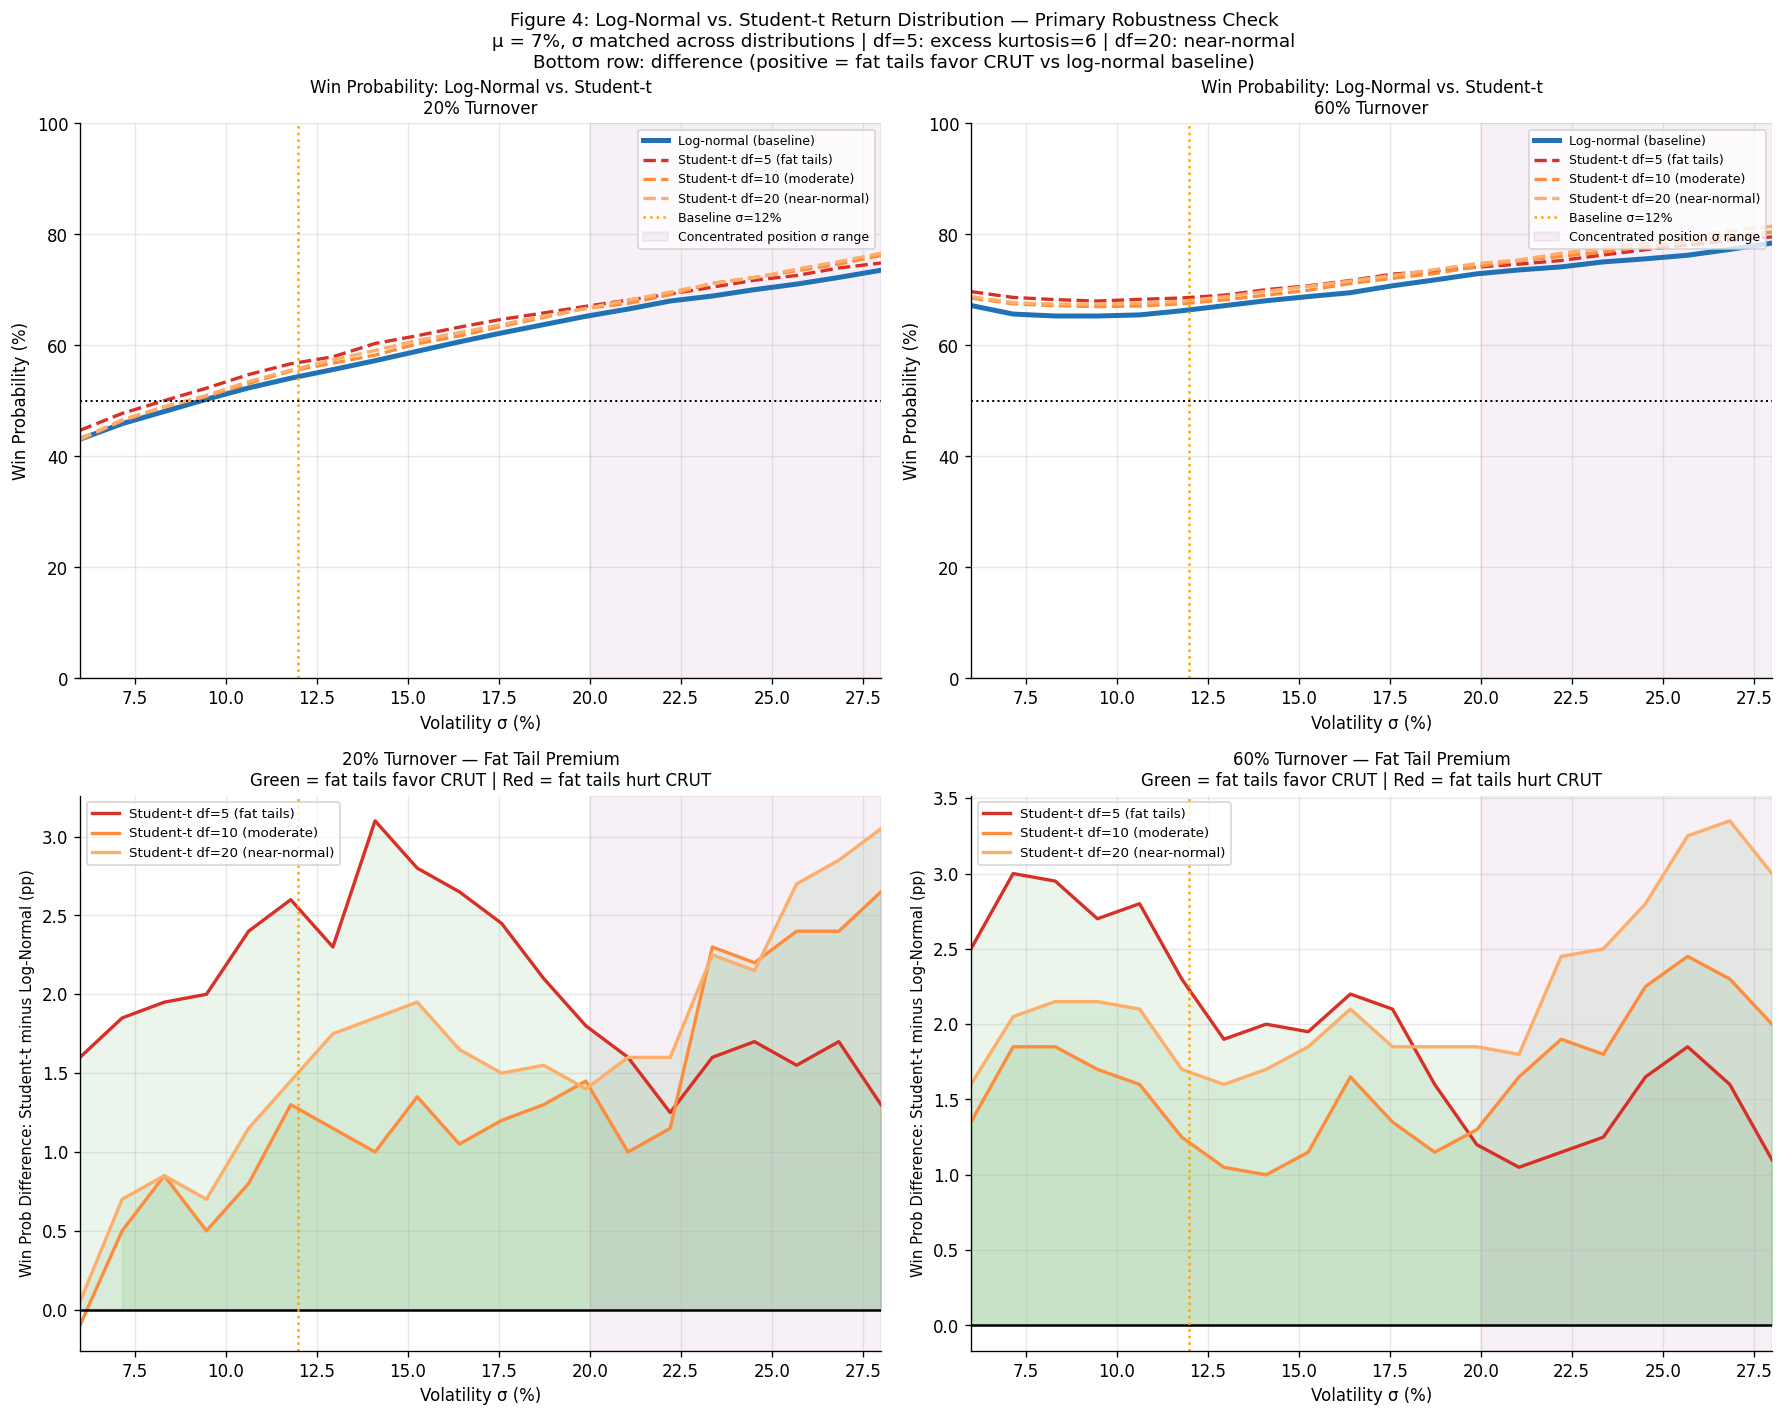

Figure 4 saved.

Win probability at baseline σ=12%:
Distribution                20% turnover   60% turnover
--------------------------------------------------------
Log-normal                         54.1%           66.2%
Student-t df=5 (fat tails)          56.7%           68.5%
Student-t df=10 (moderate)          55.4%           67.5%
Student-t df=20 (near-normal)          55.5%           68.0%


In [7]:
# --- Figure 4: Log-normal vs. Student-t primary robustness check ---

sigma_rob  = np.linspace(0.06, 0.28, 20)
df_levels  = [5, 10, 20]  # degrees of freedom: fat, moderate, near-normal
df_labels  = ['df=5 (fat tails)', 'df=10 (moderate)', 'df=20 (near-normal)']
df_colors  = ['#d73027', '#fd8d3c', '#fdae6b']

print('Running Student-t robustness check...')
print(f'  {len(sigma_rob)} sigma levels x (1 LN + {len(df_levels)} t-dist) x 2 turnover = '
      f'{len(sigma_rob)*( 1 + len(df_levels))*2} simulations')

# Log-normal baseline
wp_ln_20 = []
wp_ln_60 = []
for sg in sigma_rob:
    wp_ln_20.append(run_simulation(replace(baseline, sigma=sg, turnover=0.20,
                                           dist_type='lognormal'))['win_prob'])
    wp_ln_60.append(run_simulation(replace(baseline, sigma=sg, turnover=0.60,
                                           dist_type='lognormal'))['win_prob'])
wp_ln_20 = np.array(wp_ln_20) * 100
wp_ln_60 = np.array(wp_ln_60) * 100

# Student-t alternatives
t_results_20 = {}  # df -> wp array at 20% turnover
t_results_60 = {}  # df -> wp array at 60% turnover
for df in df_levels:
    arr_20, arr_60 = [], []
    for sg in sigma_rob:
        arr_20.append(run_simulation(replace(baseline, sigma=sg, turnover=0.20,
                                             dist_type='student_t',
                                             student_t_df=float(df)))['win_prob'])
        arr_60.append(run_simulation(replace(baseline, sigma=sg, turnover=0.60,
                                             dist_type='student_t',
                                             student_t_df=float(df)))['win_prob'])
    t_results_20[df] = np.array(arr_20) * 100
    t_results_60[df] = np.array(arr_60) * 100
    print(f'  df={df}: done')

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sg_pct = sigma_rob * 100
idx_base_sg = np.argmin(np.abs(sigma_rob - 0.12))

# Top row: 20% and 60% turnover win probability
for ax, wp_ln, t_res, tv_label in [
    (axes[0, 0], wp_ln_20, t_results_20, '20% Turnover'),
    (axes[0, 1], wp_ln_60, t_results_60, '60% Turnover'),
]:
    ax.plot(sg_pct, wp_ln, color='#2171b5', lw=3, label='Log-normal (baseline)')
    for df, label, color in zip(df_levels, df_labels, df_colors):
        ax.plot(sg_pct, t_res[df], color=color, lw=2, ls='--', label=f'Student-t {label}')
    ax.axvline(12, color='orange', lw=1.5, ls=':', label='Baseline σ=12%')
    ax.axhline(50, color='black',  lw=1.2, ls=':')
    ax.axvspan(20, 28, alpha=0.06, color='purple',
               label='Concentrated position σ range')
    ax.set_xlabel('Volatility σ (%)', fontsize=10)
    ax.set_ylabel('Win Probability (%)', fontsize=10)
    ax.set_title(f'Win Probability: Log-Normal vs. Student-t\n{tv_label}', fontsize=10)
    ax.legend(fontsize=7.5, loc='upper right')
    ax.set_xlim(sg_pct[0], sg_pct[-1])
    ax.set_ylim(0, 100)

# Bottom row: difference (Student-t minus Log-normal) — the "fat tail premium"
for ax, wp_ln, t_res, tv_label in [
    (axes[1, 0], wp_ln_20, t_results_20, '20% Turnover — Fat Tail Premium'),
    (axes[1, 1], wp_ln_60, t_results_60, '60% Turnover — Fat Tail Premium'),
]:
    for df, label, color in zip(df_levels, df_labels, df_colors):
        diff = t_res[df] - wp_ln
        ax.plot(sg_pct, diff, color=color, lw=2, label=f'Student-t {label}')
        ax.fill_between(sg_pct, diff, 0,
                        where=(diff > 0), alpha=0.08, color='green')
        ax.fill_between(sg_pct, diff, 0,
                        where=(diff < 0), alpha=0.08, color='red')
    ax.axhline(0, color='black', lw=1.5)
    ax.axvline(12, color='orange', lw=1.5, ls=':')
    ax.axvspan(20, 28, alpha=0.06, color='purple')
    ax.set_xlabel('Volatility σ (%)', fontsize=10)
    ax.set_ylabel('Win Prob Difference: Student-t minus Log-Normal (pp)', fontsize=9)
    ax.set_title(f'{tv_label}\nGreen = fat tails favor CRUT | Red = fat tails hurt CRUT', fontsize=10)
    ax.legend(fontsize=8)
    ax.set_xlim(sg_pct[0], sg_pct[-1])

fig.suptitle(
    'Figure 4: Log-Normal vs. Student-t Return Distribution — Primary Robustness Check\n'
    'μ = 7%, σ matched across distributions | df=5: excess kurtosis=6 | df=20: near-normal\n'
    'Bottom row: difference (positive = fat tails favor CRUT vs log-normal baseline)',
    fontsize=11
)
plt.tight_layout()
plt.savefig('fig4_student_t_robustness.png', bbox_inches='tight', dpi=150)
plt.show()

print('Figure 4 saved.')
print()
# Summary table at baseline sigma
print('Win probability at baseline σ=12%:')
print(f'{"Distribution":<25} {"20% turnover":>14} {"60% turnover":>14}')
print('-' * 56)
print(f'{"Log-normal":<25} {wp_ln_20[idx_base_sg]:>13.1f}%  {wp_ln_60[idx_base_sg]:>13.1f}%')
for df, label in zip(df_levels, df_labels):
    print(f'{"Student-t " + label:<25} '
          f'{t_results_20[df][idx_base_sg]:>13.1f}%  '
          f'{t_results_60[df][idx_base_sg]:>13.1f}%')

---
## Section 5 — Sequence of Returns Risk

### Figure 5: Win Probability by Return Sequence Category

The order of returns matters for strategies that distribute or consume assets over time. The CRUT pays 6% of corpus annually — a bad early return permanently reduces the corpus base, impairing all future distributions. The benchmark holds and compounds — a bad early return reduces the corpus but the full recovery potential is retained.

**This asymmetry is well known in retirement income planning** ("sequence of returns risk" or SORR) but has not been examined in the CRUT context. The question here is whether the CRUT is more or less exposed to SORR than the benchmark.

**Method:** We generate 2,000 return paths and sort them by the average return in the **first third** of the simulation horizon (years 1–11 of 33). We split into quartiles:

- **Q1 (Early Bad):** Worst 25% of first-third returns. Early losses, potential recovery later.
- **Q2 (Early Moderate-Bad):** 25th–50th percentile of first-third returns.
- **Q3 (Early Moderate-Good):** 50th–75th percentile of first-third returns.
- **Q4 (Early Good):** Best 25% of first-third returns. Early gains, potential mean reversion later.

Within each quartile, we compute win probability. If the CRUT is more exposed to SORR, win probability should be much lower in Q1 than Q4. If both strategies are equally exposed, win probability should be roughly constant across quartiles.

Running sequence of returns analysis...
  Simulation horizon: 33 yr  |  Early period: years 1-11

Win probability by quartile and turnover:
Quartile                      0%tv     20%tv     40%tv     60%tv
----------------------------------------------------------------
Q1 (Early Bad)               36.4%     63.6%     68.4%     71.6%
Q2 (Early Mod-Bad)           28.3%     55.7%     62.7%     65.1%
Q3 (Early Mod-Good)          21.7%     51.9%     60.8%     65.4%
Q4 (Early Good)              15.7%     45.4%     58.3%     64.7%


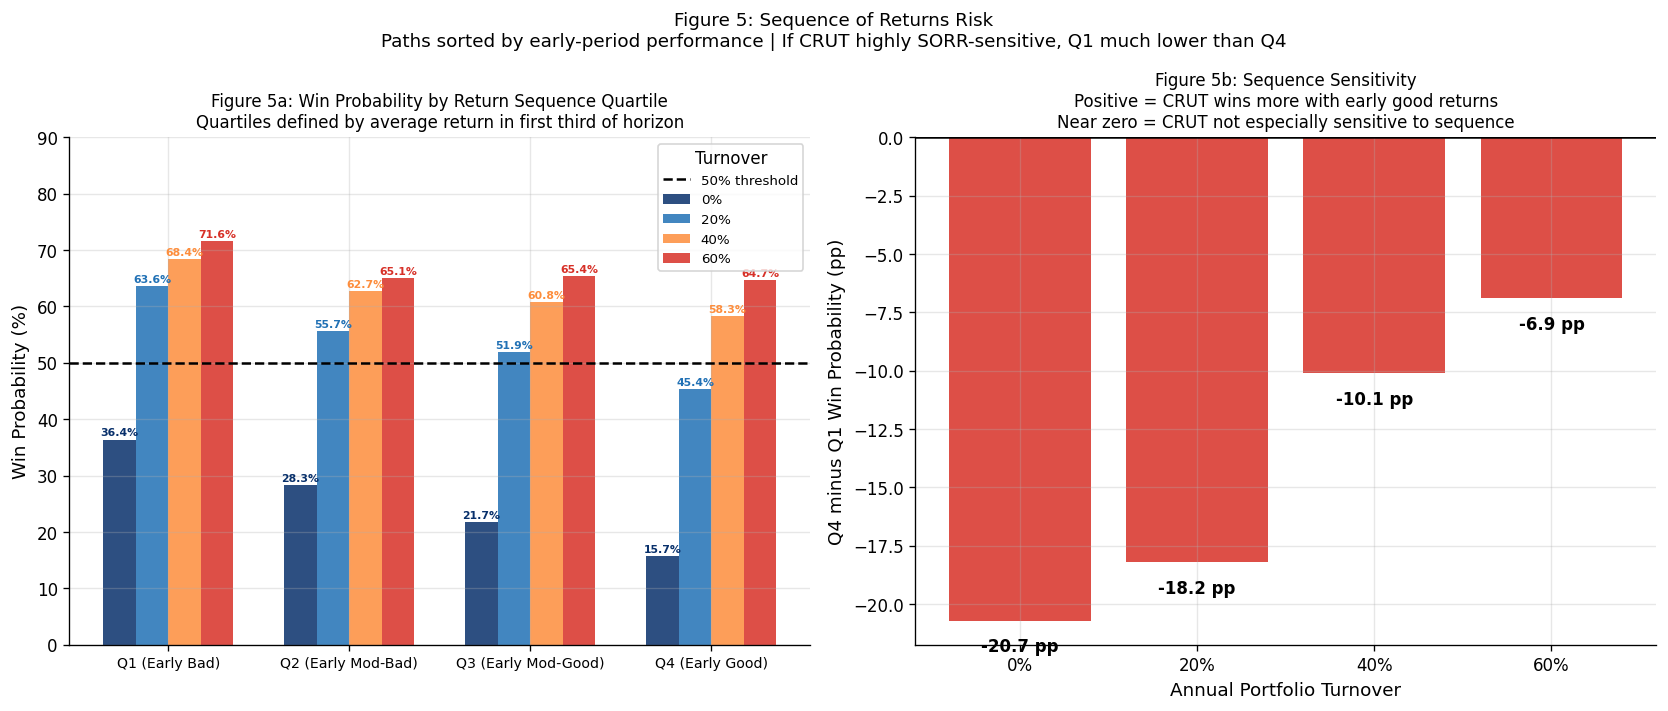

Figure 5 saved.


In [8]:
# --- Figure 5: Sequence of returns risk ---

print('Running sequence of returns analysis...')

N_PATHS = 4000   # larger sample for stable quartile statistics
T_full  = run_simulation(baseline)['T']
early_cutoff = T_full // 3   # first third of horizon

# Generate a large set of paths
np.random.seed(RANDOM_SEED)
all_paths = generate_return_paths(baseline.mu, baseline.sigma,
                                   T_full, N_PATHS, seed=RANDOM_SEED)

# Sort by average return in the first third
early_avg = all_paths[:, :early_cutoff].prod(axis=1) ** (1/early_cutoff)  # geo mean
sort_idx  = np.argsort(early_avg)
quartile_size = N_PATHS // 4
quartiles = {
    'Q1 (Early Bad)':         sort_idx[:quartile_size],
    'Q2 (Early Mod-Bad)':     sort_idx[quartile_size:2*quartile_size],
    'Q3 (Early Mod-Good)':    sort_idx[2*quartile_size:3*quartile_size],
    'Q4 (Early Good)':        sort_idx[3*quartile_size:],
}
q_colors = ['#d73027', '#fd8d3c', '#74c476', '#006d2c']

# Compute win probability within each quartile for four turnover levels
sorr_results = {}  # turnover -> {quartile_name -> wp}
for tv in TURNOVER_LEVELS:
    sorr_results[tv] = {}
    for qname, qidx in quartiles.items():
        q_paths = all_paths[qidx, :]
        q_p     = replace(baseline, n_paths=len(qidx), turnover=tv)
        r       = run_simulation(q_p, precomputed_paths=q_paths)
        sorr_results[tv][qname] = r['win_prob']

# Print SORR summary
print(f'  Simulation horizon: {T_full} yr  |  Early period: years 1-{early_cutoff}')
print()
print('Win probability by quartile and turnover:')
print(f'{"Quartile":<24}', end='')
for tv in TURNOVER_LEVELS:
    print(f'{tv*100:.0f}%tv'.rjust(10), end='')
print()
print('-' * 64)
for qname in quartiles:
    print(f'{qname:<24}', end='')
    for tv in TURNOVER_LEVELS:
        print(f'{sorr_results[tv][qname]*100:>9.1f}%', end='')
    print()

# Figure 5
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
x = np.arange(4)
q_names   = list(quartiles.keys())
width     = 0.18
offsets   = np.linspace(-(len(TURNOVER_LEVELS)-1)/2*width,
                         (len(TURNOVER_LEVELS)-1)/2*width, len(TURNOVER_LEVELS))

ax = axes[0]
for tv, tv_color, offset in zip(TURNOVER_LEVELS, TURNOVER_COLORS, offsets):
    vals = [sorr_results[tv][q]*100 for q in q_names]
    bars = ax.bar(x + offset, vals, width, color=tv_color, alpha=0.85,
                  label=f'{tv*100:.0f}%')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.3,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=6.5,
                color=tv_color, fontweight='bold')
ax.axhline(50, color='black', lw=1.5, ls='--', label='50% threshold')
ax.set_xticks(x)
ax.set_xticklabels(q_names, fontsize=8.5)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_ylim(0, 90)
ax.set_title('Figure 5a: Win Probability by Return Sequence Quartile\n'
             'Quartiles defined by average return in first third of horizon', fontsize=10)
ax.legend(title='Turnover', fontsize=8)

# Right panel: SORR slope — Q4 minus Q1 win probability
ax2 = axes[1]
sorr_slope = [(sorr_results[tv]['Q4 (Early Good)'] -
               sorr_results[tv]['Q1 (Early Bad)']) * 100
              for tv in TURNOVER_LEVELS]
colors_slope = ['#1a9641' if v > 0 else '#d73027' for v in sorr_slope]
bars2 = ax2.bar([f'{tv*100:.0f}%' for tv in TURNOVER_LEVELS],
                sorr_slope, color=colors_slope, alpha=0.85)
for bar, val in zip(bars2, sorr_slope):
    ax2.text(bar.get_x() + bar.get_width()/2,
             val + 0.3 if val >= 0 else val - 1.5,
             f'{val:+.1f} pp', ha='center', va='bottom',
             fontsize=10, fontweight='bold')
ax2.axhline(0, color='black', lw=1.5)
ax2.set_xlabel('Annual Portfolio Turnover', fontsize=11)
ax2.set_ylabel('Q4 minus Q1 Win Probability (pp)', fontsize=11)
ax2.set_title('Figure 5b: Sequence Sensitivity\n'
              'Positive = CRUT wins more with early good returns\n'
              'Near zero = CRUT not especially sensitive to sequence', fontsize=10)

fig.suptitle(
    'Figure 5: Sequence of Returns Risk\n'
    'Paths sorted by early-period performance | If CRUT highly SORR-sensitive, Q1 much lower than Q4',
    fontsize=11
)
plt.tight_layout()
plt.savefig('fig5_sequence_risk.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 5 saved.')

---
## Section 6 — Bear Market Stress Test

### Figure 6: Year-1 Shock Analysis

A bear market stress test imposes a specified return shock in year 1 and allows normal return processes from year 2 onward. This tests resilience to an adverse event immediately after CRUT formation — a practical scenario since CRUTs are often formed during periods of elevated asset values (when the contributed asset has the most appreciation), which may coincide with market peaks.

**The year-1 shock affects the two strategies differently:**

- **CRUT:** A large year-1 loss reduces the corpus permanently. Year-1 distributions are small (based on the post-loss corpus). The deduction was fixed at inception based on the pre-loss FMV — it is not affected by year-1 performance. The CRUT's recovery depends on subsequent returns compounding a smaller base.

- **Benchmark:** A large year-1 loss reduces the benchmark corpus proportionally. The embedded capital gain shrinks (or may become a loss), reducing the deferred tax liability. This is actually a *benefit* for the benchmark — the embedded gain that was generating potential tax drag is partially or fully eliminated. A -30% shock on a $1M asset with $800K embedded gain at 33.1% LTCG would reduce the asset to $700K with the gain reduced to $500K (deferred tax now $165K vs. original $265K).

The stress test therefore pits the CRUT's deduction-at-inception advantage (unaffected by year-1 performance) against the benchmark's automatic gain compression in a loss year.

We sweep year-1 shocks from -40% to +20% at all four turnover levels.

Running bear market stress test...
  0% turnover: done
  20% turnover: done
  40% turnover: done
  60% turnover: done


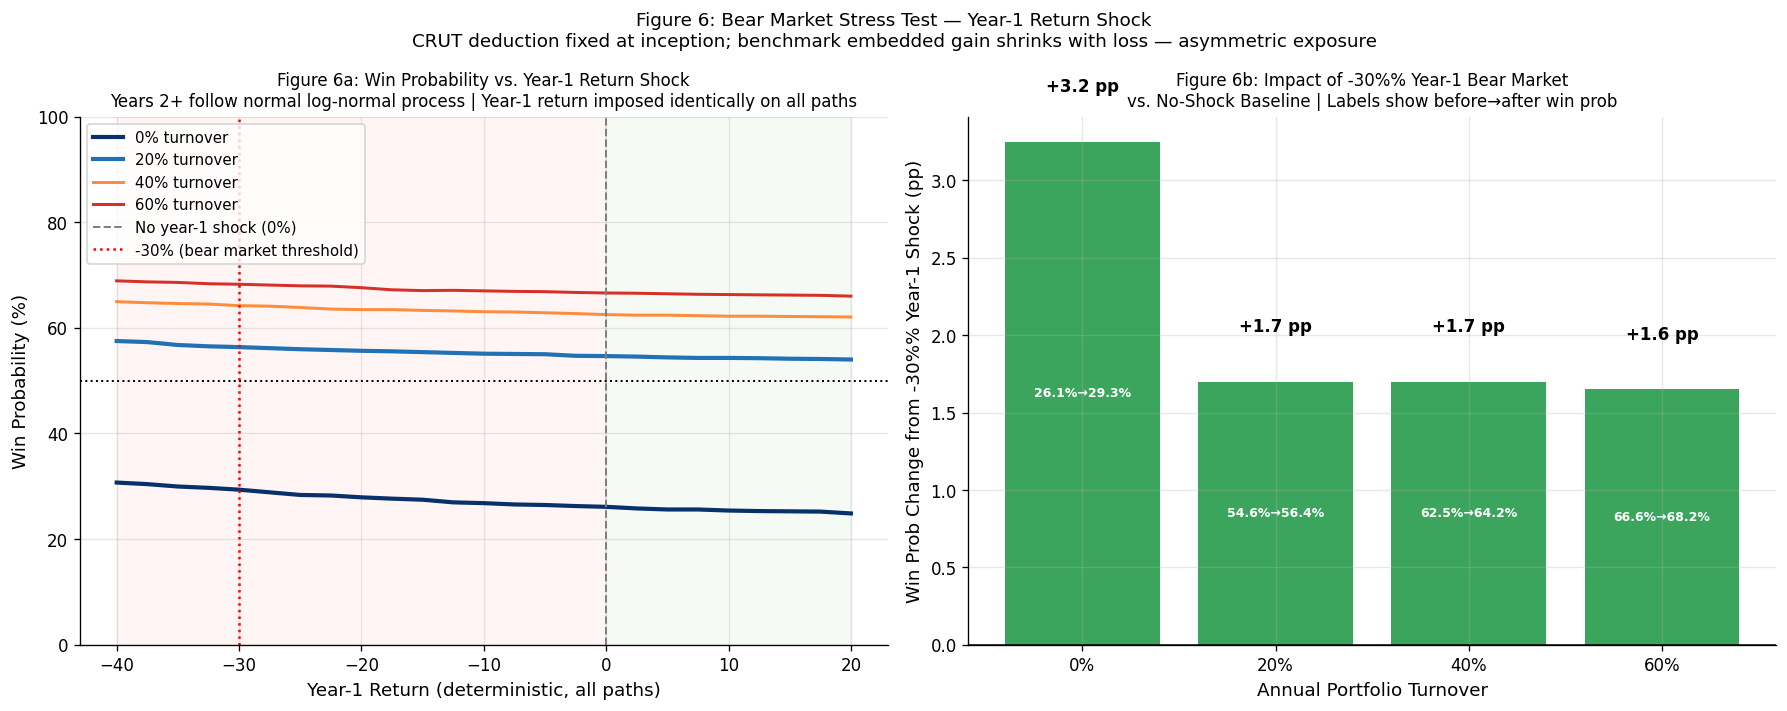

Figure 6 saved.


In [9]:
# --- Figure 6: Bear market stress test ---
# Year-1 shock sweep from -40% to +20%.
# first_year_shock is a multiplicative factor on the year-1 return:
#   shock = 0.70 -> year-1 gross return multiplied by 0.70
#   If underlying year-1 return was +7% (gross 1.07), after shock: 1.07 * 0.70 = 0.749 (-25.1%)
#   If underlying year-1 return was -5% (gross 0.95), after shock: 0.95 * 0.70 = 0.665 (-33.5%)
# To impose a DETERMINISTIC year-1 return of exactly r_shock, we override year-1
# returns for all paths. This is a cleaner stress test interpretation.

shock_returns = np.linspace(-0.40, 0.20, 25)  # year-1 return (not gross)

print('Running bear market stress test...')

shock_results = {}
for tv in TURNOVER_LEVELS:
    wp_arr = []
    for shock_r in shock_returns:
        # Generate paths normally; override year 1 for all paths
        T_run = run_simulation(baseline)['T']
        np.random.seed(RANDOM_SEED)
        paths = generate_return_paths(baseline.mu, baseline.sigma,
                                       T_run, baseline.n_paths,
                                       seed=RANDOM_SEED)
        # Override year 1: set gross return = 1 + shock_r for ALL paths
        paths[:, 0] = 1.0 + shock_r
        r = run_simulation(replace(baseline, turnover=tv, n_paths=baseline.n_paths),
                           precomputed_paths=paths)
        wp_arr.append(r['win_prob'])
    shock_results[tv] = np.array(wp_arr)
    print(f'  {tv*100:.0f}% turnover: done')

shock_pct    = shock_returns * 100
idx_baseline = np.argmin(np.abs(shock_returns - 0.07))  # close to baseline expected return
idx_zero     = np.argmin(np.abs(shock_returns - 0.0))
idx_m30      = np.argmin(np.abs(shock_returns - (-0.30)))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ax = axes[0]
for tv, color, tv_label, lw in zip(
        TURNOVER_LEVELS, TURNOVER_COLORS, TURNOVER_LABELS, [2.5,2.5,1.8,1.8]):
    ax.plot(shock_pct, shock_results[tv]*100,
            color=color, lw=lw, label=f'{tv*100:.0f}% turnover')

ax.axhline(50, color='black', lw=1.2, ls=':')
ax.axvline(0,  color='gray',  lw=1.2, ls='--', label='No year-1 shock (0%)')
ax.axvline(-30, color='red', lw=1.5, ls=':', label='-30% (bear market threshold)')
ax.axvspan(-40, 0, alpha=0.04, color='red')    # loss region
ax.axvspan(0, 20, alpha=0.04, color='green')   # gain region

ax.set_xlabel('Year-1 Return (deterministic, all paths)', fontsize=11)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_title('Figure 6a: Win Probability vs. Year-1 Return Shock\n'
             'Years 2+ follow normal log-normal process | '
             'Year-1 return imposed identically on all paths', fontsize=10)
ax.legend(fontsize=9)
ax.set_ylim(0, 100)

# Right panel: at -30% shock, compare to no-shock baseline
ax2 = axes[1]
shock_impact = [(shock_results[tv][idx_m30] - shock_results[tv][idx_zero]) * 100
                for tv in TURNOVER_LEVELS]
colors_impact= ['#d73027' if v < 0 else '#1a9641' for v in shock_impact]
bars = ax2.bar([f'{tv*100:.0f}%' for tv in TURNOVER_LEVELS],
               shock_impact, color=colors_impact, alpha=0.85)
for bar, val in zip(bars, shock_impact):
    ax2.text(bar.get_x() + bar.get_width()/2,
             val - 1.5 if val < 0 else val + 0.3,
             f'{val:+.1f} pp', ha='center', va='top' if val < 0 else 'bottom',
             fontsize=10, fontweight='bold')
ax2.axhline(0, color='black', lw=1.5)

# Annotate with actual win prob values
for i, (tv, impact) in enumerate(zip(TURNOVER_LEVELS, shock_impact)):
    wp_no_shock = shock_results[tv][idx_zero] * 100
    wp_shock    = shock_results[tv][idx_m30]  * 100
    ax2.annotate(f'{wp_no_shock:.1f}%→{wp_shock:.1f}%',
                 xy=(i, impact/2),
                 ha='center', va='center',
                 fontsize=7.5, color='white', fontweight='bold')

ax2.set_xlabel('Annual Portfolio Turnover', fontsize=11)
ax2.set_ylabel('Win Prob Change from -30%% Year-1 Shock (pp)', fontsize=11)
ax2.set_title('Figure 6b: Impact of -30%% Year-1 Bear Market\n'
              'vs. No-Shock Baseline | Labels show before→after win prob', fontsize=10)

fig.suptitle(
    'Figure 6: Bear Market Stress Test — Year-1 Return Shock\n'
    'CRUT deduction fixed at inception; benchmark embedded gain shrinks with loss — '
    'asymmetric exposure',
    fontsize=11
)
plt.tight_layout()
plt.savefig('fig6_stress_test.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 6 saved.')

In [10]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print('=' * 65)
print('NOTEBOOK 06 — RETURN MODEL ROBUSTNESS: KEY FINDINGS')
print('=' * 65)
print()

print('1. Path count convergence (Figure 1):')
for n, ci in zip(path_counts, conv_ci):
    flag = ' <-- 2pp threshold' if ci < 2.0 and (path_counts.index(n) == 0 or
                                                    conv_ci[path_counts.index(n)-1] >= 2.0) else ''
    print(f'   n={n:>6}: CI width = {ci:.2f} pp{flag}')
print()

print('2. Volatility sweep (Figure 2) — win prob at 20% turnover:')
for sv, label in [(0.12,'σ=12% (baseline)'), (0.20,'σ=20%'), (0.28,'σ=28%')]:
    idx = np.argmin(np.abs(sigma_vals - sv))
    print(f'   {label}: {vol_results[0.20][idx]:.1%}')
print()

print('3. Student-t robustness (Figure 4) at baseline σ=12%, 20% turnover:')
print(f'   Log-normal:       {wp_ln_20[idx_base_sg]:.1f}%')
for df, label in zip(df_levels, df_labels):
    print(f'   Student-t {label}: {t_results_20[df][idx_base_sg]:.1f}%  '
          f'(diff={t_results_20[df][idx_base_sg]-wp_ln_20[idx_base_sg]:+.1f} pp)')
print()

print('4. Sequence of returns risk (Figure 5) at 20% turnover:')
for qname in quartiles:
    print(f'   {qname}: {sorr_results[0.20][qname]:.1%}')
slope_20 = sorr_results[0.20]['Q4 (Early Good)'] - sorr_results[0.20]['Q1 (Early Bad)']
print(f'   Q4-Q1 range: {slope_20*100:.1f} pp')
print()

print('5. Bear market stress test (Figure 6) — -30%% year-1 shock:')
for tv, tv_label in zip([0.20, 0.60], ['20% turnover', '60% turnover']):
    base = shock_results[tv][idx_zero] * 100
    after= shock_results[tv][idx_m30]  * 100
    print(f'   {tv_label}: {base:.1f}% → {after:.1f}% ({after-base:+.1f} pp)')
print()

import os
figures = ['fig1_convergence.png', 'fig2_volatility_sweep.png',
           'fig3_mu_sigma_heatmap.png', 'fig4_student_t_robustness.png',
           'fig5_sequence_risk.png', 'fig6_stress_test.png']
print('Figure completion check:')
for f in figures:
    print(f"  {'OK' if os.path.exists(f) else 'MISSING'} {f}")
print()
print('Notebook 06 complete. All six robustness checks finished.')
print('Manuscript analysis series: NB00-NB06 complete.')

NOTEBOOK 06 — RETURN MODEL ROBUSTNESS: KEY FINDINGS

1. Path count convergence (Figure 1):
   n=   200: CI width = 13.61 pp
   n=   500: CI width = 8.37 pp
   n=  1000: CI width = 5.99 pp
   n=  2000: CI width = 4.39 pp
   n=  3000: CI width = 3.54 pp
   n=  5000: CI width = 2.75 pp
   n=  7500: CI width = 2.25 pp
   n= 10000: CI width = 1.90 pp <-- 2pp threshold

2. Volatility sweep (Figure 2) — win prob at 20% turnover:
   σ=12% (baseline): 54.8%
   σ=20%: 65.8%
   σ=28%: 74.0%

3. Student-t robustness (Figure 4) at baseline σ=12%, 20% turnover:
   Log-normal:       54.1%
   Student-t df=5 (fat tails): 56.7%  (diff=+2.6 pp)
   Student-t df=10 (moderate): 55.4%  (diff=+1.3 pp)
   Student-t df=20 (near-normal): 55.5%  (diff=+1.4 pp)

4. Sequence of returns risk (Figure 5) at 20% turnover:
   Q1 (Early Bad): 63.6%
   Q2 (Early Mod-Bad): 55.7%
   Q3 (Early Mod-Good): 51.9%
   Q4 (Early Good): 45.4%
   Q4-Q1 range: -18.2 pp

5. Bear market stress test (Figure 6) — -30%% year-1 shock:
   2